- Student Name: Xiuwen (Alice) Zhu
- Student ID: 1149188
- Course Code: COMP647
- Course Examiner: Professor Don Kulasiri
- Due Date: 03/11/2025

# Project Plan

1.	Feature engineering and feature selection as appropriate to your dataset. Briefly explain and justify what you do using comments in your Python code.

2.	Use appropriate machine learning algorithms (supervised and/or unsupervised) to perform forecasting, classification or clustering tasks with respect to your dataset. Justify why the respective algorithms are selected.
3.	Conduct performance measures in the algorithm evaluations and justify the selected the performance measures would be the most appropriate to evaluate the algorithms chosen. 
4.	Explain how you avoid over fitting and underfitting of the algorithms. 
5.	Perform appropriate explainable AI techniques to discover which features are influencing the predictions


# Research Questions
**1. As an entrepreneur, I want to know:**

Which sub-categories have had good sale performance in November based on their number of reviews and occurence in every november of the year.

**2. As the company, I want to know:**

Which sellers are likely to continue to receive high ratings for their products in the coming year?




# Import the Neccessary Libaries for Machine Learning

In [91]:
import itertools
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns    
import hdbscan  
import os
from scipy.spatial.distance import cdist         
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from matplotlib.patches import Ellipse
from scipy.spatial.distance import mahalanobis


# Read Data from CSV

In [65]:
file_path = 'cleaned_amazon_ecommerce.csv' # Define the file path for the dataset.
df = pd.read_csv (file_path)

# View Dataset

In [66]:
df.shape

(9983, 20)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         9983 non-null   object 
 1   product_name                    9983 non-null   object 
 2   number_of_reviews               9983 non-null   int64  
 3   cleaned_price                   9983 non-null   float64
 4   stock_quantity                  9983 non-null   int64  
 5   stock_condition                 9983 non-null   object 
 6   average_review_rating_out_of_5  9983 non-null   float64
 7   main_category                   9983 non-null   object 
 8   sub_category                    9983 non-null   object 
 9   item_weight_in_kg               9983 non-null   float64
 10  recommended_minimum_age_years   9983 non-null   float64
 11  purchase_month                  9983 non-null   int64  
 12  purchase_year                   99

In [68]:
df.head(2)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name,main_category_encoded,sub_category_encoded,seller_name_encoded,sales,month_sin,month_cos
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,4,2014,Amazon.co.uk,17,81,84,17.10,8.660254e-01,-0.5
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,2,16.99,3,new,4.5,Hobbies,Model Trains & Railway Sets,0.2,3.0,12,2015,UHD WHOLESALE,17,81,1588,50.97,-2.449294e-16,1.0


# Research Question 1

Which sub-categories have had good sale performance in November based on their number of reviews and occurence in every november of the year.

## Build Machine Learning Model

In [69]:
# I want to analyse product sales in November using the previous November data, because this is when festive season shopping starts.
# Although low review count does not means low sale, high review count usually means high sales.
# Therefore, I will use review_count as a proxy for sales.
# Also because this is an analysis of sales over years, an unsupervised ML model will be used to cluster the sub-categorries.
# A KMeans model will be used, as it can cluster data points based on feature similarity using the mean of number of reviews and ratings.


# Step 1: Filter the data for November purchases only.
nov_df = df[df['purchase_month'] == 11].copy() # Filter the dataframe for November data only throughout the years.
YEARS_RANGE = list(range(2001, 2016))
TOTAL_NOVEMBER_YEARS = len(YEARS_RANGE)

In [70]:
# Step 2: For each sub_category, aggregate necessary statistics for November data.
grouped_yearly = (
    nov_df
    .groupby(['sub_category', 'purchase_year'])['number_of_reviews']
    .sum()
    .reset_index()
)


# I have explored selecting different features to generate the clusterings for the KMeans model.
# After testing multiple combinations, I settled with number of reviews and purchase years to capture both popularity and consistency of sales.
# The reason for not using purchase_month is because the dataframe is already filtered for November only.


In [71]:
# Step 3: Preprocess features by applying log transformation to the data to reduce skewness and aggregate the data by sub_category.

grouped_yearly['number_of_reviews_log'] = np.log1p(grouped_yearly['number_of_reviews'])
# Apply logarithmic transformation to number_of_reviews to reduce skewness.

agg = grouped_yearly.groupby('sub_category').agg(
    median_reviews_nov=('number_of_reviews_log', 'median'), 
    occurrence_count=('purchase_year', 'nunique') # This counts the occurence of years a sub-category has sales in November.
).reset_index()

agg['prop_nov_years'] = agg['occurrence_count'] / TOTAL_NOVEMBER_YEARS
agg['median_reviews_nov'] = agg['median_reviews_nov'].fillna(0)


# KMean clustering assumes normal distributed data and is sensitive to outliers. 
# So the purpose of using log transformation is to reduce the influence of outliers and standardise the skewed distributions, so that the clustering algorithm can perform effectively.
# I explored using the mean number_of_reviews_log, but found that it caused feature dominance issues in the clustering.
# This may due to some sub-categories having extreme high review counts in certain years, which skews the mean.
# However, if I take out those extreme values (outliers), then I am losing important information about the sales patterns/information.
# Some products under certain sub-categories may have seasonal spikes in sales, which are important for understanding sales trends and answering this research question.
# Therefore, to avoid losing this information, and not getting affected by the extreme values using mean, I decided to try median.
# Using the median was effective in reducing the influence of extreme values while still capturing the central tendency of review counts.

In [72]:
# Step 4: Prepare feature matrix.

features = agg[['median_reviews_nov', 'occurrence_count']].values
scaler = StandardScaler() 
features_scaled = scaler.fit_transform(features)

# The median_reviews_nov value are significantly larger than occurrence_count values.
# Therefore, standardisation or normalisation is commonly applied to bring all feature to the same scale.
# Standardissation is to transform the data to all have a standard diviation of 1.
# Normalisation is to scale the data to a range between 0 and 1.
# Given that KMeans model uses distance to group similar data points into clusters, standardisation is more appropriate as it remains the distances between data points.
# Unpon research online, it was confirmed that standardisation is often preferred for KMeans clustering.


=== Silhouette and Inertia Results for KMeans (median + standardized) ===
 k   Inertia  Silhouette_Score
 2 74.474169          0.466449
 3 48.658083          0.442839
 4 35.085844          0.427939
 5 27.855673          0.407279
 6 22.131194          0.406087
 7 17.579168          0.423941
 8 14.222836          0.445616
 9 12.549888          0.424119


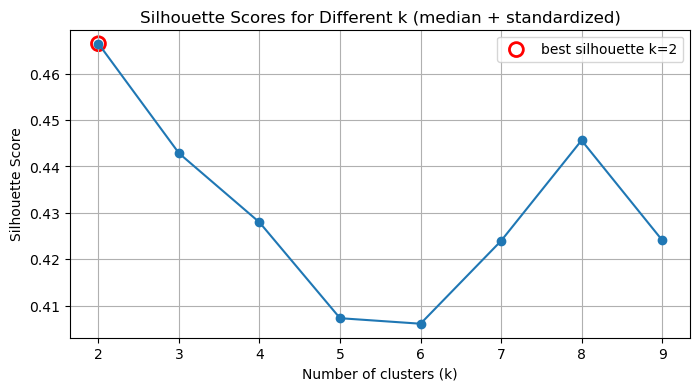

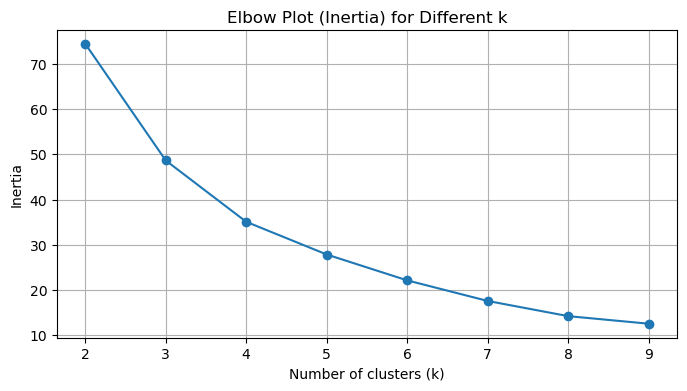

In [73]:
# Step 5: Evaluate the K values using silhouette score.

inertias = [] 
# An inertia score evaluates the quality of a clustering model. 
# This score is calculated by sum all the squared distances to get the total inertia score for the entire dataset.
# It measures how tightly the data points are clustered around their centroids.
# The score range from 0 to infinity.
# A lower inertia indicates that the data points are closer to their respective cluster centroids, which is desirable.

sil_scores = []
# A silhouette score measures how similar a data point is to its own cluster compared to other clusters.
# The silhouette score ranges from -1 to 1.
# A higher silhouette score (near 1) indicates better-defined clusters, so the highest K is normally chosen.

ks = range(2, 10) 
# Test k values range from 2 to 9 to find the optimal number of clusters.
# The reason that it starts from 2 is that if it is 1, then all data points are in 1 cluster.

RANDOM_STATE = 42
# random_state=42 ensures reproducibility of results.

for k in ks:
    kmeans_tmp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=50)
    # n_clusters=k sets the number of clusters.
    # n_init=50 means runs the algorithm will run 50 times with different starting points, and keeping the best solution.

    labels_tmp = kmeans_tmp.fit_predict(features_scaled) 
    # labels_tmp assigns each data point to a cluster.
    # fit_predit is to fit the KMeans model to the scaled data.
    
    inertias.append(kmeans_tmp.inertia_) 
    sil_scores.append(silhouette_score(features_scaled, labels_tmp))
    # Collecting both inertia and silhouette scores for each k.
    # Can't use rely on inertia alone to determine the optimal K. 
    # Best to use both inertia and silhouette scores together to make decision.

silhouette_results = pd.DataFrame({
    "k": list(ks),
    "Inertia": inertias,
    "Silhouette_Score": sil_scores
})

print("\n=== Silhouette and Inertia Results for KMeans (median + standardized) ===")
print(silhouette_results.to_string(index=False))

# Plot silhouette
plt.figure(figsize=(8,4))
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Scores for Different k (median + standardized)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
best_k_sil = int(silhouette_results.loc[silhouette_results['Silhouette_Score'].idxmax(), 'k'])
best_sil = silhouette_results['Silhouette_Score'].max()
plt.scatter([best_k_sil], [best_sil], s=100, facecolors='none', edgecolors='red', linewidths=2, label=f'best silhouette k={best_k_sil}')
plt.legend()
plt.show()

# Plot inertia (elbow)
plt.figure(figsize=(8,4))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Plot (Inertia) for Different k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


# I have explored multiple k values ranges to find the highest silhouette score.
# I have also explored adjusting feature selection and preprocessing steps to improve the clustering results.
# I discovered that when more features are added, more variance and noises presents, does not help with reinforcing the separation between clusters.
# However, it does not mean that adding more features is always bad, as it depedns on the nature of the data and the aim of the including those features.

In [97]:
# Step 6: I want to adjust the k value manually to explore different cluster presentations and see how the clustering results vary.

CHOSEN_K = 8  # <--- adjust this to explore different cluster numbers
print(f"\nUsing user-chosen k = {CHOSEN_K} instead of silhouette-best k = {best_k_sil}")


# A different k value will give different clusterting results.
# In most cases, the silhouette-best (highest) k will give the most optimal clustering results.
# However, in my case, the best silhouette k=2 at 0.466449 gives two clusters and it doesn not provide enough breakdown information about the sub-categories.
# The research question is to look into the sales patterns of different sub-categories in November over the years, so a more detailed clustering breakdown is preferred.
# Based on the combination silhouette scores and the inertia scores, I trust K=8 provides a good balance between cluster detail and quality.
# Therefore, I am choosing K=8 for my final clustering analysis.

# One thing I would like to note is that although all the silhouette scores are below 0.5, providing only moderate clustering quality, it is not due to poor feature selection or prepocessing.
# The nature of this data has presence of overlapping characteristics among sub-categories, as the sales pattern between many sub-categories may not be very distinct.
# Such nature of the data is causing the clusters to be less separated and the silhouette scores to be lower, despite many efforts were put into feature selection and engineering.
# Also, the irregular shape of the clusters deviates from the ideal spherical shape that KMeans assumes, further contributing to the moderate silhouette scores.
# However, despite the moderate silhouette scores, the clustering results still provide insightful information about the sales patterns of different sub-categories in November over the years.


Using user-chosen k = 8 instead of silhouette-best k = 2


In [75]:
# Step 7: Fit KMean model with chosen k

kmeans = KMeans(n_clusters=CHOSEN_K, random_state=RANDOM_STATE, n_init=50)
agg['cluster'] = kmeans.fit_predict(features_scaled)
agg['median_reviews_nov_scaled'] = features_scaled[:, 0] # Adding scaled median reviews for November to the agg dataframe, column 0.
agg['occurrence_count_scaled'] = features_scaled[:, 1] # Adding scaled occurrence count to the agg dataframe, column 1.

In [76]:
# Step 8: Convert centroids back to original space and compute cluster scores

centroids_scaled = kmeans.cluster_centers_
# The centroids are are stored in the same scaled feature space for training the KMeans model.
centroids_original = scaler.inverse_transform(centroids_scaled)
# Reverse the scaling back to the original feature, same as how the features were scaled before training.
# The purpose of converting the standardised centroids back to original space (the actual data values) is to make the cluster centroids understandable in the context of the original data.
centroid_df = pd.DataFrame(centroids_original, columns=['median_reviews_nov','occurrence_count'])
# A dataframe is created to store the centroids in original feature space.
centroid_df['cluster'] = centroid_df.index
# Create a cluster column to identify each centroid, showing the meadian number of reviews and occurrence count for each cluster.
centroid_df['score'] = centroid_df['median_reviews_nov'] + centroid_df['occurrence_count'] / TOTAL_NOVEMBER_YEARS
# A scoring metric is created that combines both selected features to rank the clusters.

In [77]:
# Step 9: Label the clusters to human understandable labels in descending order, with 0 being the best.

centroid_df = centroid_df.sort_values('score', ascending=False).reset_index(drop=True)
# Sorting the centroids by their score from highest to lowest, hence it is asending=False.
centroid_df['cluster_label'] = centroid_df.index  
# Label the clusters in descending order, with 0 being the best cluster (highest score).
cluster_label_map = dict(zip(centroid_df['cluster'], centroid_df['cluster_label']))
# A mapping dictionary is created to link the old cluster numbers to new labels, so that cluster 0 is always the best cluster.
agg['cluster_label'] = agg['cluster'].map(cluster_label_map)
# Apply the mapping by aggretating the new cluster label to the main dataframe.
centroid_df['cluster'] = centroid_df['cluster_label']
# Update centroid_df by replacing the old cluster number with the new labels that are human understandable.
centroid_df = centroid_df.drop(columns='cluster_label')
# Drop the cluster_label column.

best_cluster = 0
# Define the best cluster as cluster 0.

In [78]:
# Step 10: Storing outputs.

OUTPUT_SUMMARY_CSV = "november_subcategory_clusters.csv" 
# Define a file name that stores the clustering results.
agg_sorted = agg.sort_values(['cluster_label', 'median_reviews_nov', 'occurrence_count'], ascending=[True, False, False])
# Sort the full dataset by cluster label, then by median reviews and occurrence count within each cluster for better readability.
agg_sorted.to_csv(OUTPUT_SUMMARY_CSV, index=False)
# The output is saved into the defined CSV file, it contains the full clustering results for all sub-categories. No column was added to the original dataframe.
# This would be the final output for data interpretation and analysis. 

print("\nCluster centroids (original units, sorted by score):")
print(centroid_df[['cluster','median_reviews_nov','occurrence_count','score']])
print(f"\nBest-performing cluster (high median reviews & high occurrence): cluster {best_cluster}")
print(f"Saved detailed results to: {os.path.abspath(OUTPUT_SUMMARY_CSV)}")



Cluster centroids (original units, sorted by score):
   cluster  median_reviews_nov  occurrence_count     score
0        0            4.204976          1.400000  4.298310
1        1            3.802775          6.875000  4.261109
2        2            3.370134          4.333333  3.659023
3        3            2.287028          6.300000  2.707028
4        4            2.171965          3.375000  2.396965
5        5            2.126241          1.166667  2.204018
6        6            1.107678          4.000000  1.374345
7        7            0.931136          1.400000  1.024469

Best-performing cluster (high median reviews & high occurrence): cluster 0
Saved detailed results to: /Users/xiuwen/Documents/GitHub/1149188/COMP647/november_subcategory_clusters.csv


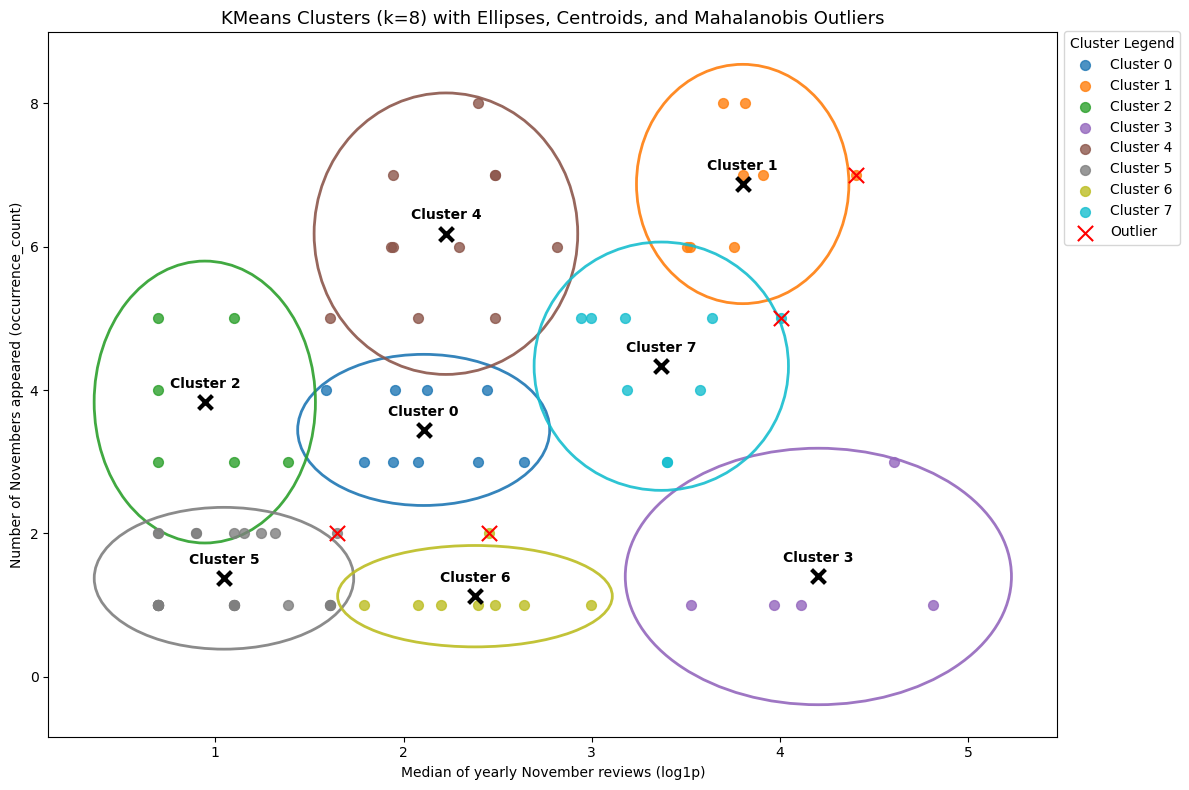

In [106]:


# -------------------------------
# 3. Outlier Detection (Mahalanobis Distance)
# -------------------------------
agg['is_outlier'] = False

for c in range(k):
    cluster_data = agg[agg['cluster'] == c]
    if len(cluster_data) < 3:
        continue  # skip small clusters

    Xc = cluster_data[['median_reviews_nov', 'occurrence_count']].values
    cov = np.cov(Xc, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    mean_vec = np.mean(Xc, axis=0)

    # Mahalanobis distance for each point
    distances = [mahalanobis(x, mean_vec, inv_cov) for x in Xc]
    threshold = 2.0  # sensitive; try 2.5 or 3 for stricter
    outlier_mask = np.array(distances) > threshold

    agg.loc[cluster_data.index, 'is_outlier'] = outlier_mask

# -------------------------------
# 4. Visualization
# -------------------------------
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, k))

for c, color in zip(range(k), colors):
    cluster_data = agg[agg['cluster'] == c]
    plt.scatter(cluster_data['median_reviews_nov'], cluster_data['occurrence_count'],
                s=50, color=color, label=f"Cluster {c}", alpha=0.8)

    # Ellipse boundary (2 std)
    x_mean, y_mean = cluster_data['median_reviews_nov'].mean(), cluster_data['occurrence_count'].mean()
    x_std, y_std = cluster_data['median_reviews_nov'].std(), cluster_data['occurrence_count'].std()

    ellipse = Ellipse((x_mean, y_mean),
                      width=2*x_std*2, height=2*y_std*2,
                      edgecolor=color, facecolor='none', lw=2, alpha=0.9)
    plt.gca().add_patch(ellipse)

    # Plot centroid
    centroid = centroids.loc[c]
    plt.scatter(centroid['median_reviews_nov'], centroid['occurrence_count'],
                color='black', marker='x', s=100, linewidths=3)

    # Label placed slightly *above* centroid marker, no border
    plt.text(x_mean, y_mean + 0.2,  # offset label above centroid
             f"Cluster {c}",
             fontsize=10, fontweight='bold', ha='center', color='black')

# Highlight outliers (red X)
plt.scatter(agg.loc[agg['is_outlier'], 'median_reviews_nov'],
            agg.loc[agg['is_outlier'], 'occurrence_count'],
            color='red', marker='x', s=120, label='Outlier')

# -------------------------------
# 5. Final Touches
# -------------------------------
plt.title(f"KMeans Clusters (k={k}) with Ellipses, Centroids, and Mahalanobis Outliers", fontsize=13)
plt.xlabel("Median of yearly November reviews (log1p)")
plt.ylabel("Number of Novembers appeared (occurrence_count)")
plt.legend(bbox_to_anchor=(1, 0.85), loc='center left', title="Cluster Legend", fontsize=10)
plt.tight_layout()
plt.show()

# I will later try to further tune the clusters by identifying the outliers using algorithm like DBSCAN to see if can improve the clustering quality.

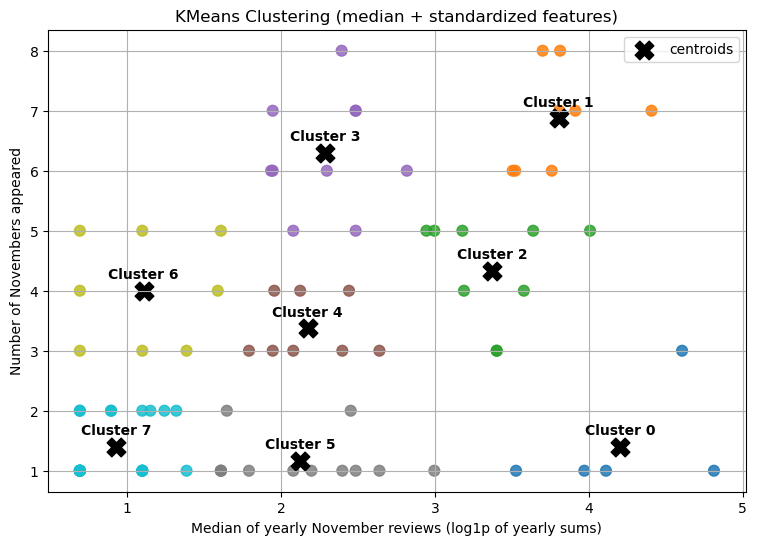

In [79]:
# Step 11: Plot clusters with cluster labels on centroids.

plt.figure(figsize=(9,6))
plt.scatter(
    agg['median_reviews_nov'], # x-axis: median reviews in November
    agg['occurrence_count'], # y-axis: occurrence count
    c=agg['cluster_label'], 
    cmap='tab10', # colour map for different clusters. The tab10 gives 10 different colours.
    s=60, # Marker size for readability.
    alpha=0.85 # Transparency for visibility.
)
plt.scatter(
    centroid_df['median_reviews_nov'], 
    centroid_df['occurrence_count'], 
    c='black', 
    s=180, # Marker size for the centroid dots.
    marker='X', # Shape of the centroid markers.
    label='centroids'
)

# Step 12: Add a lable to each centroid.
for i, row in centroid_df.iterrows(): # i stands for the index (0,1,2,...), and row contains the centroid data for that index.
    plt.text(
        row['median_reviews_nov'], 
        row['occurrence_count'] + 0.2,  # + 0.2 is a small offset above the centroid so that it does not overlap with the marker.
        f"Cluster {int(row['cluster'])}",
        fontsize=10,
        fontweight='bold',
        ha='center'
    )

plt.xlabel('Median of yearly November reviews (log1p of yearly sums)')
plt.ylabel('Number of Novembers appeared')
plt.title('KMeans Clustering (median + standardized features)')
plt.grid(True)
plt.legend()
plt.show()

In [80]:
# Step 13:  Print top sub-categories in best cluster

best_subcats = agg[agg['cluster_label'] == best_cluster].sort_values('median_reviews_nov', ascending=False)
print("\nTop sub-categories in the best-performing cluster for November:")
print(best_subcats[['sub_category','median_reviews_nov','occurrence_count']].to_string(index=False))


Top sub-categories in the best-performing cluster for November:
          sub_category  median_reviews_nov  occurrence_count
             Chocolate            4.812184                 1
   Kites & Flight Toys            4.605170                 3
          Garden Tools            4.110874                 1
           Blackboards            3.970292                 1
Schoolbags & Backpacks            3.526361                 1


In [81]:
# Step 14: Provide detailed listing of sub-categories per cluster

print("\nDetailed sub-category listing per cluster (sorted by median_reviews_nov):")

# Sort agg for readability
agg_sorted_clusters = agg.sort_values(['cluster_label', 'median_reviews_nov'], ascending=[True, False])

# Loop through each cluster and print a readable table
for cluster_id, group in agg_sorted_clusters.groupby('cluster_label'):
    print(f"\nCluster {cluster_id}")
    print("-" * 30)
    for _, row in group.iterrows():
        print(f"{row['sub_category']} (median={row['median_reviews_nov']:.3f}, occur={int(row['occurrence_count'])})")


# Although sub-categories in Cluster 0 have the highesst median number of reviews, the occurence counts are not so high.
# In comparison, sub-categories in Cluster 1 have slightly lower median number of reviews, but it has significantly higher occurence counts.
# As a result, sub-categories in Cluster 1 may be a better proxy for consistent November sales over the years.


Detailed sub-category listing per cluster (sorted by median_reviews_nov):

Cluster 0
------------------------------
Chocolate (median=4.812, occur=1)
Kites & Flight Toys (median=4.605, occur=3)
Garden Tools (median=4.111, occur=1)
Blackboards (median=3.970, occur=1)
Schoolbags & Backpacks (median=3.526, occur=1)

Cluster 1
------------------------------
Accessories (median=4.407, occur=7)
Star Wars (median=3.912, occur=7)
Unknown (median=3.813, occur=8)
Card Games (median=3.807, occur=7)
Hasbro (median=3.759, occur=6)
Toy Vehicles & Accessories (median=3.699, occur=8)
Children's Craft Kits (median=3.521, occur=6)
Science Fiction & Fantasy (median=3.505, occur=6)

Cluster 2
------------------------------
Disney (median=4.007, occur=5)
Toy Trains & Accessories (median=3.638, occur=5)
Banners, Stickers & Confetti (median=3.577, occur=4)
Colouring Pens & Markers (median=3.401, occur=3)
Trivia & Quiz Games (median=3.401, occur=3)
Dice & Dice Games (median=3.188, occur=4)
Jigsaws (median=3.

## Tuning Model

[Running DBSCAN for outlier detection]


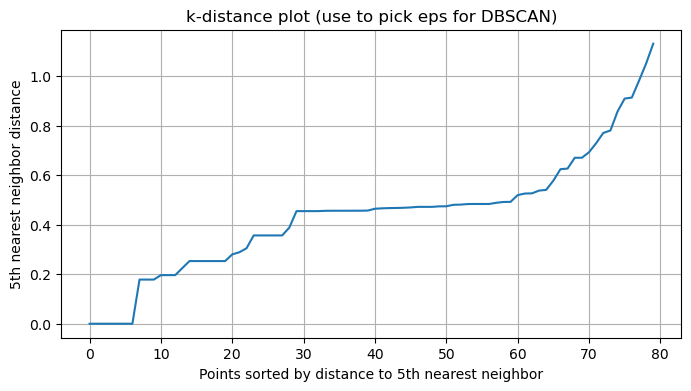

In [82]:
# Step 1: Preparing DBSCAN althorithm to detect outliers to adjust the density of clusters.

print("[Running DBSCAN for outlier detection]")

features_scaled = scaler.fit_transform(features) 
# Use same standardised features as KMeans model.
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(features_scaled)
# This is to create a nearest neighbour model to find the nearest data point for the cluster.
# The n_neighbour function tells how many neighbbours/data points are needed to form a dense cluster.
distances, indices = nbrs.kneighbors(features_scaled)
# The 'distances' is the distance arrangement between each data point, that considered to be its nearest neighbours.
# The 'indices' is the corresponding row numbers of those nearest neighbours.
k_distances = np.sort(distances[:, -1])
# This code provides a sorted array of the distances from smallest to largest, that reflects the density of the data.
# The 'distances[:, -1]' extracts the distances of the furtherest data point among the min_samples's nearest neighbour.

plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.xlabel(f"Points sorted by distance to {min_samples}th nearest neighbor")
plt.ylabel(f"{min_samples}th nearest neighbor distance")
plt.title("k-distance plot (use to pick eps for DBSCAN)")
plt.grid(True)
plt.show()


# Given that the cluster shapes shown in the KMean model are irregular, I decided to use DBSCAN to identify the outliers as noises.
# Those outliers are the ones that are far away from the intra cluster centroids, which can be ignored during data interpretation.

In [83]:
# Step 2: Run DBSCAN algorithm.

eps_to_use = eps_manual
# Setting up the epsilon value for DBSCAN.
# This value determines the maximum distance between two samples to be considered as neighbours for each intra-cluster.
# eps_manual is to allow for manual adjustment.
print(f"Running DBSCAN with eps={eps_to_use}, min_samples={min_samples}")

db = DBSCAN(eps=eps_to_use, min_samples=min_samples, metric='euclidean')
# Grouping data points that are thats many neigbours, and marks points that appear as outliers (noise).
# Euclidean distance is used to measure how close data points are.
db_labels = db.fit_predict(features_scaled)
# Run DBSCAN on clustering and get the labels for each data point.

Running DBSCAN with eps=0.57, min_samples=5


In [84]:
# Step 3: Demonstrate the DBSCAN results for analysis.

eps_local = 0.45   # start small; tweak as needed per cluster
min_samples_local = 3

agg['dbscan_within_cluster'] = 0  # default (0 = inlier)

for cid in sorted(agg['cluster_label'].unique()):
    cluster_mask = (agg['cluster_label'] == cid)
    X_cluster = features_scaled[cluster_mask]
    if len(X_cluster) < min_samples_local:
        # skip very small clusters
        agg.loc[cluster_mask, 'dbscan_within_cluster'] = 0
        continue

    db_local = DBSCAN(eps=eps_local, min_samples=min_samples_local, metric='euclidean')
    cluster_labels = db_local.fit_predict(X_cluster)
    agg.loc[cluster_mask, 'dbscan_within_cluster'] = cluster_labels  # -1 = outlier

# summary of noise counts per KMeans cluster
summary_within = (
    agg.groupby('cluster_label')['dbscan_within_cluster']
       .apply(lambda s: (s == -1).sum())
       .reset_index(name='num_outliers')
)
summary_within['total_points'] = agg.groupby('cluster_label').size().values
summary_within['percent_outliers'] = 100 * summary_within['num_outliers'] / summary_within['total_points']
print("\n=== Outliers per KMeans cluster (DBSCAN run within clusters) ===")
print(summary_within.to_string(index=False))


# This step runs 
# When I use the reulting DBSCAN values for eps=0.57 and min_samples=5, clusters 0 and 6 are shown to have 100% outliers.
# Meanwhile, the remaining clusters have 0% outliers.
# This result is suggesting that only clusters 0 and 6 have irregular cluster shapes and low datapoint density issues.
# However, this is not the case, as other clusters also have irregular cluster shapes.
# The eps=0.57 and min_samples=5 is not suitable for the majority of the clusters.
# Therefore, I will try to adjust the eps and min_samples values to improve the DBSCAN results.
# The DBSCAN results appear reasonable for most clusters when eps=0.45 and min_samples=3 are used.
# Only clusters 4 and 7 are shown to have 0% outliers, which is convencing given their realatively compact datapoint distributions.
# The remaining clusters are shown to have outliers at different severity, which is true given the distribution of the datapoints at intra-cluster and the resulting irregular shapes of the clusters.


=== Outliers per KMeans cluster (DBSCAN run within clusters) ===
 cluster_label  num_outliers  total_points  percent_outliers
             0             2             5         40.000000
             1             2             8         25.000000
             2             4             9         44.444444
             3             7            10         70.000000
             4             0             8          0.000000
             5             2            12         16.666667
             6             2             8         25.000000
             7             0            20          0.000000


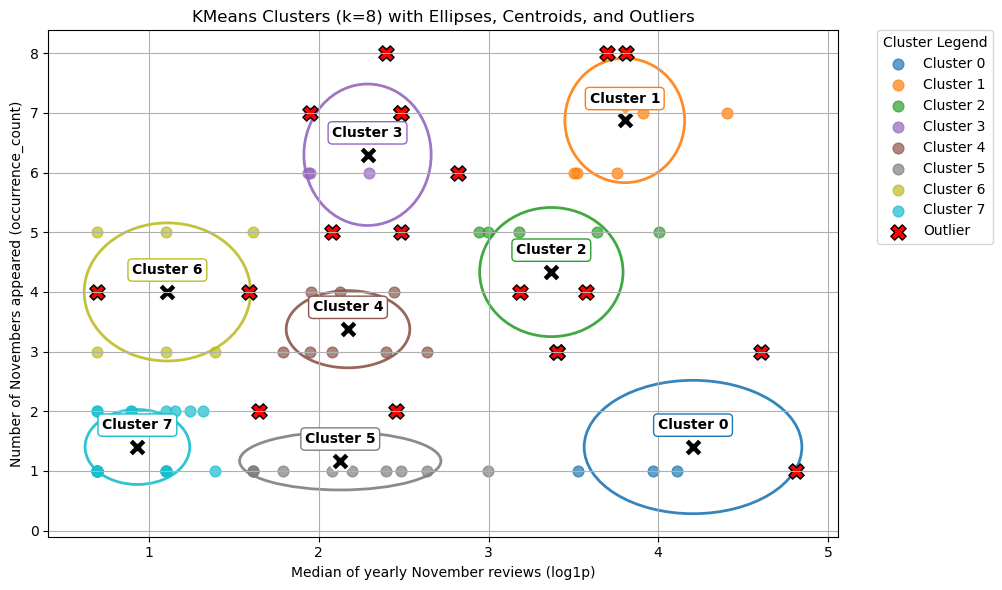

In [85]:

# Step 4: Plot KMeans clusters again with DBSCAN outliers highlighted

plt.figure(figsize=(12,6))

# Define colors for each cluster (tab10 supports up to 10 easily)
colors = plt.cm.tab10(np.linspace(0, 1, len(centroid_df)))

for idx, (cluster_id, color) in enumerate(zip(sorted(agg['cluster_label'].unique()), colors)):
    cluster_data = agg[agg['cluster_label'] == cluster_id]
    
    # Plot points for this cluster
    plt.scatter(cluster_data['median_reviews_nov'],
                cluster_data['occurrence_count'],
                s=60, color=color, alpha=0.7, label=f'Cluster {cluster_id}')
    
    # Calculate ellipse size (std dev around centroid)
    x_mean, y_mean = cluster_data['median_reviews_nov'].mean(), cluster_data['occurrence_count'].mean()
    x_std, y_std = cluster_data['median_reviews_nov'].std(), cluster_data['occurrence_count'].std()
    
    ellipse = Ellipse((x_mean, y_mean),
                      width=2.5*x_std, height=2.5*y_std,  # radius ~2.5 std
                      edgecolor=color, facecolor='none', lw=2, alpha=0.9)
    plt.gca().add_patch(ellipse)
    
    # Mark centroid with black "X"
    cx = centroid_df.loc[centroid_df['cluster'] == cluster_id, 'median_reviews_nov'].values[0]
    cy = centroid_df.loc[centroid_df['cluster'] == cluster_id, 'occurrence_count'].values[0]
    plt.scatter(cx, cy, color='black', marker='X', s=180, edgecolors='white', linewidths=1.5)
    
    # Add centroid label slightly above the centroid
    plt.text(cx, cy + 0.3, f"Cluster {cluster_id}",
             fontsize=10, fontweight='bold', ha='center', color='black',
             bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.3'))

# Highlight DBSCAN outliers if present
if 'dbscan_within_cluster' in agg.columns:
    outliers = agg[agg['dbscan_within_cluster'] == -1]
    if not outliers.empty:
        plt.scatter(outliers['median_reviews_nov'],
                    outliers['occurrence_count'],
                    c='red', edgecolors='black', s=120, marker='X', label='Outlier')

plt.xlabel('Median of yearly November reviews (log1p)')
plt.ylabel('Number of Novembers appeared (occurrence_count)')
plt.title(f'KMeans Clusters (k={CHOSEN_K}) with Ellipses, Centroids, and Outliers')

# ✅ Move legend outside the plot (right side)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=True, title="Cluster Legend")

plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for legend
plt.show()

# In this final plot, the KMeans clusters are visualised with ellipses and outliers highlighted in red X markers, calculated using DBSCAN.
# Each ellipse represents the spread  of the data points within a cluster.
# However, some outliers are presenting inside of the ellipses. 
# This is because the ellipses are only for visual approximations, they are the actual boundary shapes determined by KMeans or DBSCAN.
# Moreover, DBSCAN determines by local neighbourhood density, not the distance from the cluster centroid.
# Hence, some outliers may appear within the ellipses, because they are far from their intra-cluster neighbours, despite being close to the cluster centroid.
# And for datapoints that fall outside of the ellipses, but not marked as outliers, is because they are close to their intra-cluster neighbours, despite being far from the cluster centroid.




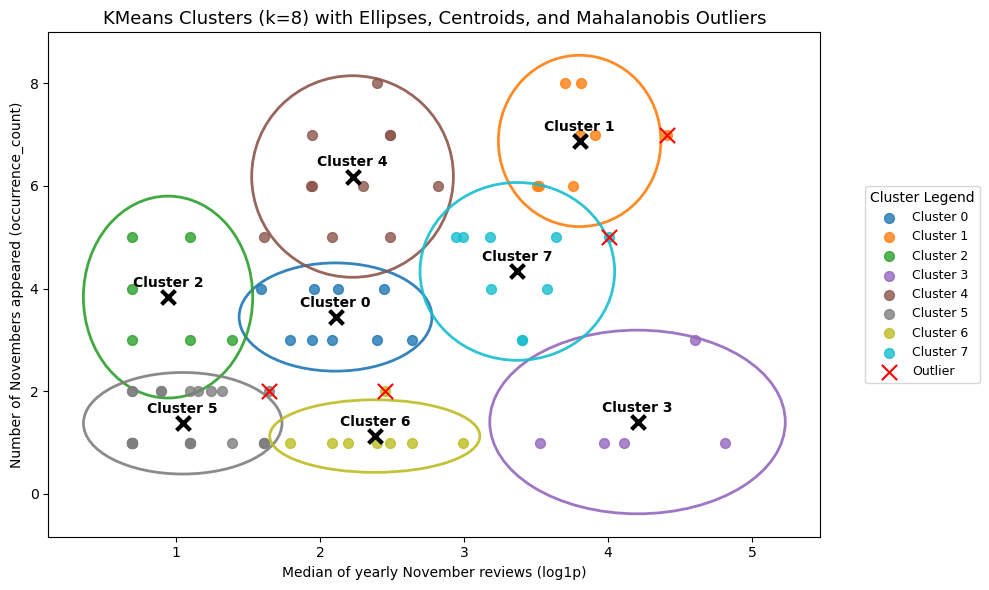

In [ ]:


# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(agg[['median_reviews_nov', 'occurrence_count']])

# -------------------------------
# 2. KMeans Clustering
# -------------------------------
k = 8  # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
agg['cluster'] = kmeans.fit_predict(X_scaled)

centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=['median_reviews_nov', 'occurrence_count'])
centroids = pd.DataFrame(scaler.inverse_transform(centroids_scaled),
                         columns=['median_reviews_nov', 'occurrence_count'])
centroids['cluster'] = range(k)

# -------------------------------
# 3. Outlier Detection (Mahalanobis Distance)
# -------------------------------
agg['is_outlier'] = False

for c in range(k):
    cluster_data = agg[agg['cluster'] == c]
    if len(cluster_data) < 3:
        continue  # skip small clusters

    Xc = cluster_data[['median_reviews_nov', 'occurrence_count']].values
    cov = np.cov(Xc, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    mean_vec = np.mean(Xc, axis=0)

    # Mahalanobis distance for each point
    distances = [mahalanobis(x, mean_vec, inv_cov) for x in Xc]
    threshold = 2.0  # sensitive; try 2.5 or 3 for stricter
    outlier_mask = np.array(distances) > threshold

    agg.loc[cluster_data.index, 'is_outlier'] = outlier_mask

# -------------------------------
# 4. Visualization
# -------------------------------
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, k))

for c, color in zip(range(k), colors):
    cluster_data = agg[agg['cluster'] == c]
    plt.scatter(cluster_data['median_reviews_nov'], cluster_data['occurrence_count'],
                s=50, color=color, label=f"Cluster {c}", alpha=0.8)

    # Ellipse boundary (2 std)
    x_mean, y_mean = cluster_data['median_reviews_nov'].mean(), cluster_data['occurrence_count'].mean()
    x_std, y_std = cluster_data['median_reviews_nov'].std(), cluster_data['occurrence_count'].std()

    ellipse = Ellipse((x_mean, y_mean),
                      width=2*x_std*2, height=2*y_std*2,
                      edgecolor=color, facecolor='none', lw=2, alpha=0.9)
    plt.gca().add_patch(ellipse)

    # Plot centroid
    centroid = centroids.loc[c]
    plt.scatter(centroid['median_reviews_nov'], centroid['occurrence_count'],
                color='black', marker='x', s=100, linewidths=3)

    # Label placed slightly *above* centroid marker, no border
    plt.text(x_mean, y_mean + 0.2,  # offset label above centroid
             f"Cluster {c}",
             fontsize=10, fontweight='bold', ha='center', color='black')

# Highlight outliers (red X)
plt.scatter(agg.loc[agg['is_outlier'], 'median_reviews_nov'],
            agg.loc[agg['is_outlier'], 'occurrence_count'],
            color='red', marker='x', s=120, label='Outlier')

# -------------------------------
# 5. Final Touches
# -------------------------------
plt.title(f"KMeans Clusters (k={k}) with Ellipses, Centroids, and Mahalanobis Outliers", fontsize=13)
plt.xlabel("Median of yearly November reviews (log1p)")
plt.ylabel("Number of Novembers appeared (occurrence_count)")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title="Cluster Legend", fontsize=9)
plt.tight_layout()
plt.show()